# Data Download

This notebook download all FITS data.
List of files is in file `ondrejov-labeled-spectra.csv`.
These spectra has been classified with
[Spectral View](https://github.com/podondra/spectralview) tool.

In [1]:
LABELS_FILE = 'data/ondrejov-labeled-spectra.csv'
%ls $LABELS_FILE

data/ondrejov-labeled-spectra.csv


In [2]:
import urllib.request
import urllib.parse
import io
import os
import glob
from functools import partial
from itertools import count
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

## Read CSV with Labels

In [3]:
labeled_idents = np.genfromtxt(
    LABELS_FILE,
    delimiter=',',   # CSV file
    dtype=None,      # guess dtypes automatically
    skip_header=1    # first he
)
labeled_idents.shape, labeled_idents

((13335,), array([(b'ivo://asu.cas.cz/stel/ccd700/uc050029', 2),
        (b'ivo://asu.cas.cz/stel/ccd700/sd150065', 1),
        (b'ivo://asu.cas.cz/stel/ccd700/oj140028', 1), ...,
        (b'ivo://asu.cas.cz/stel/ccd700/rd260049', 0),
        (b'ivo://asu.cas.cz/stel/ccd700/ti110051', 1),
        (b'ivo://asu.cas.cz/stel/ccd700/a201409230031', 1)], 
       dtype=[('f0', 'S43'), ('f1', '<i8')]))

In [4]:
# each public id is unique and set operation will be usefull later
spectra_idents = set()
for ident, label in labeled_idents:
    # ident is binary string so convert it to python unicode string
    spectra_idents.add(ident.decode('ascii'))

len(spectra_idents)

13335

## Simple Spectral Access protocol

This is not much revlevant now since only datalink is used
to download normalized spectra.

SSAP, SSA defines a uniform intreface to remotely discover
and access one dimenisonal spectra. Spectral data access
mmay involve active transformation of data. SSA also
defines complete metadata to describe the available
datasets. It makes use of VOTable for metadata exchange.

### Architecture

A query is used for data discovery and to negotiate the
details of the static or dynamically created dataset
to be retrieved. SSA allows to mediate not only dataset
metadata but the actual dataset itself. Direct access to
data is also provided.

A single service may support multiple operation to perform
various functions. The current interface use an HTTP GET
request to submit parametrized requests with responses
being returned as for example FITS or VOTable. Defined
operations are the following:

1. A queryData operation return a VOTable describing
candidate datasets.
2. A getData operation is used to access an individual
dataset.

In [5]:
def request_url(url):
    '''Make HTTP request and return response data.'''
    with urllib.request.urlopen(url) as response:
         data = response.read()
    return data

## Datalink

Datalink is a service for working with spectra.
I don't really understand what is it but it do normalization automatically.
For information about the one which is used here see
http://vos2.asu.cas.cz/ccd700/q/sdl/info.

In [6]:
datalink_service = 'http://vos2.asu.cas.cz/ccd700/q/sdl/dlget'

def make_datalink_url(
    pub_id, fluxcalib=None, wave_min=None, wave_max=None,
    file_format='application/fits', url=datalink_service
):
    url_parameters = {'ID': pub_id}
    if fluxcalib:
        url_parameters['FLUXCALIB'] = fluxcalib
    if wave_min and wave_max:
        url_parameters['BAND'] = str(wave_min) + ' ' + str(wave_max)
    if file_format:
        url_parameters['FORMAT'] = file_format
    
    return url + '?' + urllib.parse.urlencode(url_parameters)

make_datalink_url(
    'ivo://asu.cas.cz/stel/ccd700/sh270028',
    fluxcalib='normalized',
    wave_min=6500e-10, wave_max=6600e-10
)

'http://vos2.asu.cas.cz/ccd700/q/sdl/dlget?FLUXCALIB=normalized&BAND=6.5e-07+6.6e-07&ID=ivo%3A%2F%2Fasu.cas.cz%2Fstel%2Fccd700%2Fsh270028&FORMAT=application%2Ffits'

## Show 'fluxcalib' Parameters

To show how to work with datalink
and what it offers.
From this is obvious that the 'normalized' setting is the desired.

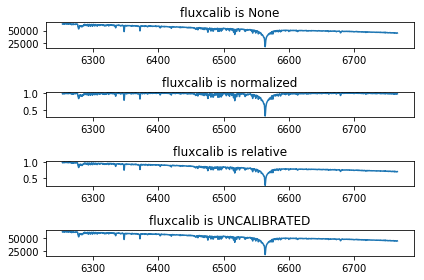

In [7]:
def plot_fluxcalib(fluxcalib, ax):
    # create the datalink service URL
    datalink_url = make_datalink_url('ivo://asu.cas.cz/stel/ccd700/sh270028', fluxcalib=fluxcalib)
    # download the data
    fits_data = request_url(datalink_url)
    # open the data as file
    hdulist = fits.open(io.BytesIO(fits_data))
    # plot it
    ax.set_title('fluxcalib is ' + str(fluxcalib))
    ax.plot(hdulist[1].data['spectral'], hdulist[1].data['flux'])

fluxcalibs = [None, 'normalized', 'relative', 'UNCALIBRATED']
f, axs = plt.subplots(4, 1)

for fluxcalib, ax in zip(fluxcalibs, axs):
    plot_fluxcalib(fluxcalib, ax)

plt.tight_layout()

## FITS Download

In [8]:
def download_spectrum(pub_id, n, directory, fluxcalib, minimum=None, maximum=None):
    # get the name from public id
    name = pub_id.split('/')[-1]
    # directory HAS TO end with '/'
    path = directory + name + '.fits'
    url = make_datalink_url(pub_id, fluxcalib, minimum, maximum)
    
    print('{:5} downloading {}'.format(n, name))
    
    try:
        data = request_url(url)
    except Exception as e:
        print(e)
        return name
    
    with open(path, 'wb') as f:
        f.write(data)

In [9]:
FITS_DIR = 'ssap/'
%mkdir $FITS_DIR 2> /dev/null

ondrejov_downloader = partial(
    download_spectrum,
    directory=FITS_DIR,
    fluxcalib='normalized'
)

In [10]:
ccd700_prefix = 'ivo://asu.cas.cz/stel/ccd700/'

def get_pub_id(path, prefix=ccd700_prefix):
    return prefix + os.path.splitext(os.path.split(path)[-1])[0]

get_pub_id('ssap/uh260033.fits')

'ivo://asu.cas.cz/stel/ccd700/uh260033'

In [11]:
spectra_idents -= set(map(get_pub_id, glob.glob(FITS_DIR + '*.fits')))
if len(spectra_idents) != 0:
    donwload_info = list(map(ondrejov_downloader, spectra_idents, count(start=1)))
print('All spectra downloaded.')

All spectra downloaded.
